
<font color=#0DAC0B>
<p align='center'><font size=6><b> Проектное задание-1 <br>«Угадай знаменитость»</b> </font></font></p>

-----------------------------------
<p align='center'><img src="https://drive.google.com/uc?export=download&id=1XP3k0Cj9zBRbyCYVK6Z6slPv91ANKTqQ" width="300"></img></p>  
  
<i>«Никто не может угадать, какая знаменитость знаменитее» (известная цитата)</i>
  
------------------------------------------  
  

In [1]:
import os
import torch
import random
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from PIL import Image
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
BATCH_SIZE = 32

<br>
<font color=#0DAC0B>
<font size=5><b>1. Постановка задачи</font>
</font>  
  
-------------------------------------------------

<p align='center'><img src="https://lms-cdn.skillfactory.ru/assets/courseware/v1/8c3ed80a5e98e9930fa8262c0eb61cba/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/cv_project1_1_1.png" width="300"></img></p>  

1. Скачать и загрузить <a href="https://drive.google.com/file/d/120xqh0mYtYZ1Qh7vr-XFzjPbSKivLJjA/view?usp=sharing"><font color=#C4EAFF>датасет</font></a>.  
  
2. Отрисовать один батч загруженных данных.  
  
3. Выбрать предобученную модель.  
  
4. Обучить многоклассовый классификатор, используя выбранную модель.  
  
5. Визуализировать предсказания модели.  
  
6. Сделать выводы по полученным результатам.  
  
Основная цель ─ добиться `accuracy > 0.85` на валидационной выборке и визуализировать результаты.  
  
*Дополнительно проведу обучение на трёх предобученных сетях и сравню результаты.*
  
--------------------

<br>
<font color=#0DAC0B>
<font size=5><b>2. Предварительная подготовка. Скачивание и загрузка датасета</font>
</font>  
  
-------------------------------------------------

Инициализируем все необходимые переменные и списки.  Подключим необходимый девайс.

In [2]:
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print('Connected device:', device)

musk = 'https://drive.google.com/uc?export=download&id=1BOuq35QzO1YtKQkYGfj_vtBj3Ps5xyBN'
gates ='https://drive.google.com/uc?export=download&id=1jgHQF_NMpH9uMTvic9rGnURu_8UOGdiz'
bezos = 'https://drive.google.com/uc?export=download&id=1n5UaLL-TAkjIeBbTNcn-Czkp_A3Eslhj'
zuker = 'https://drive.google.com/uc?export=download&id=1ncPmYTg6EPHlUFdcjl_bXTbtWRLv2DXy'
jobs = 'https://drive.google.com/uc?export=download&id=1TX3hiRyvSYiYVZUFrbAhN3Jpp9cd0Q9s'

face_lst=[
    ["Elon Musk",'data/musk500.jpg'],
    ["Bill Gates",'data/gates500.jpg'],
    ["Jeff Besoz",'data/bezos500.jpg'], 
    ["Mark Zuckerberg", 'data/zuckerberg500.jpg'], 
    ["Steve Jobs",'data/jobs500.jpg']
]

Connected device: cuda


Загрузим данные в zip-файле, распакуем их в каталог `data`. Скачаем картинки знаменитостей размером 500 × 500, которые понадобятся нам для тестирования.

In [3]:
import wget
from zipfile import ZipFile

os.mkdir('data')

url = 'https://drive.google.com/uc?export=download&id=120xqh0mYtYZ1Qh7vr-XFzjPbSKivLJjA'
file_name = wget.download(url, 'data/')

with ZipFile(file_name, 'r') as zip_file:
    zip_file.extractall()

link_lst = [musk, gates, bezos, zuker, jobs]
for link in link_lst:
    wget.download(link, 'data/')

Зададим вспомогательные функции вывода картинок и графиков.

In [4]:
# Функция вывода картинок.  
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(2 * num_samples, 1.5))
    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " ").title())
        axes[i].axis('off')
    plt.show()

# Функция вывода графиков.  
def plot_chart(loss_t, loss_v, acc_t, acc_v):
    m_val = str(max(acc_v).round(4))
    plt.figure(figsize=(12, 4),facecolor='lightblue')
    len_l = range(len(loss_t))
    for i in range(121, 123):
        lst = [loss_t, loss_v, 'Loss', 'Epochs'] if i==121 else \
            [acc_t, acc_v, 'Accuracy', 'Epochs\n\nValidate accuracy: '+m_val]
        plt.subplot(i)
        plt.plot(len_l, lst[0],'o-', color='b', label='train')
        plt.plot(len_l, lst[1],'o-', color='r', label='valid')
        plt.legend(fontsize=10, edgecolor='red', labelcolor='#9E1316')
        plt.grid()
        plt.title(lst[2])
        plt.xlabel(lst[3])
    plt.show();

# Функция вывода тестовых картинок и предсказаний.  
def face_predict(model, face):
    plt.figure(figsize=(15, 3))
    for i, name in enumerate(face_lst):
        image = Image.open(name[1]).convert('RGB')
        tensor = valid_dataset.transform(image)
        batch = torch.stack([tensor])
        with torch.no_grad():
            x = model(batch.to(device)).to(device)
        pred = x.argmax().item()
        pred_title = train_dataset.classes[pred].replace('_', ' ').title()
        plt.subplot(1, len(face_lst), i+1)
        plt.title(str(i+1)+':  '+name[0])
        plt.imshow(image)
        plt.xlabel('\n'+'predict:\n'+pred_title, c='r', fontsize=11)
    plt.show();

<br>
<font color=#0DAC0B>
<font size=5><b>3. Отрисовка одного батча загруженных картинок</font>
</font>  
  
-------------------------------------------------

Отрисуем один батч случайных картинок в папках `train` и `valid`.

train


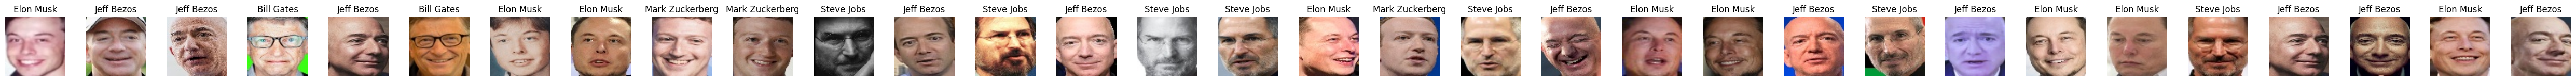

valid


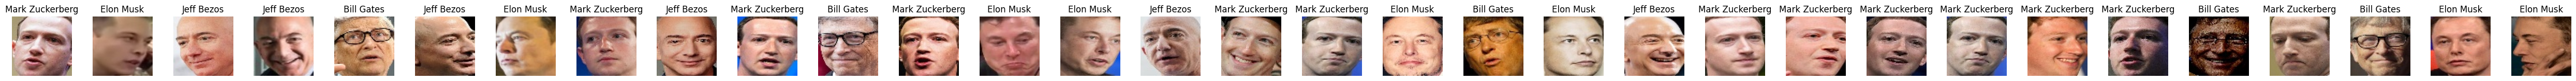

In [5]:
print('train')
plot_samples(ImageFolder('data/train/'), BATCH_SIZE)
print('valid')
plot_samples(ImageFolder('data/valid/'), BATCH_SIZE)

<br>
<font color=#0DAC0B>
<font size=5><b>4. Создание датасетов train и valid. Создание загрузчиков данных. Препроцессинг </font>
</font>  
  
-------------------------------------------------

Обучающие и валидационные данные у нас расположены в папках с соответствующими названиями ─ train и valid.  
С помощью `ImageFolder()` создаём обучающий и валидационный датасеты:

In [6]:
# Training dataset.  
train_dataset = ImageFolder(
    root='data/train'
)
# Validation dataset.  
valid_dataset = ImageFolder(
    root='data/valid'
)

Вначале выполним препроцессинг данных `train` и `valid`, дополнительно добавив аугментацию автоконтраста и выравнивания изображений.  
Затем, используя `DataLoader()`, создадим загрузчики данных. 

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(), 
    normalize
])

valid_dataset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.ToTensor(),
    normalize
])

# Training data loaders.  
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True 
)
# Validation data loaders.  
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, 
    shuffle=False 
)

<br>
<font color=#0DAC0B>
<font size=5><b>5. Выбор предобученных моделей. Тонкая настройка</font>
</font>  
  
-------------------------------------------------

Функция выбора и настройки предобученной сети `GoogLeNet`.  
Меняем выходной параметр `Liner(out_feature=1000)` на количество классов.  
Замораживаем все слои, кроме последних двух.

In [8]:
def google():
    model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(1024, len(train_dataset.classes))
    for param in model.parameters():
        param.requires_grad = True
    model.inception3a.requires_grad = False
    model.inception3b.requires_grad = False
    model.inception4a.requires_grad = False
    model.inception4b.requires_grad = False
    model.inception4c.requires_grad = False
    model.inception4d.requires_grad = False
    model.inception4e.requires_grad = False
    return model


Функция выбора и настройки предобученной сети `VGG19`.  
Меняем выходной параметр `Liner(out_feature=1000)` на количество классов.  
Замораживаем все слои, кроме последних трёх.

In [9]:
def vgg_19():
    model = models.vgg19(weights =models. VGG19_Weights.IMAGENET1K_V1)
    model.classifier[6] = torch.nn.Linear(4096, len(train_dataset.classes))
    for param in model.features.parameters():
        param.requires_grad = False 
    for index, block in enumerate(model.features):
        if index >= 30:
            for param in block.parameters():
                param.requires_grad = True
    return model

Функция выбора и настройки предобученной сети `Efficient_B7`.  
Меняем выходной параметр `Liner(out_feature=1000)` на количество классов.  
Замораживаем все слои, кроме последних двух.

In [10]:
def efficient():
    model = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.IMAGENET1K_V1)
    model.classifier[1] = torch.nn.Linear(2560, len(train_dataset.classes))
    for params in model.parameters():
        params.requires_grad = False
    for index, block in enumerate(model.features):
        if index >= 8:
            for params in block.parameters():
                params.requires_grad = True
    return model

<br>
<font color=#0DAC0B>
<font size=5><b>6. Обучение многоклассового классификатора. Визуализация предсказаний моделей</font>
</font>  
  
-------------------------------------------------

Определяем функцию обучения модели.

In [11]:
def train(model, optimizer, train_loader, val_loader, epoch=10):
    loss_train, acc_train = [], []
    loss_valid, acc_valid = [], []
    for epoch in tqdm(range(epoch)):
        losses, equals = [], []
        torch.set_grad_enabled(True)
        
        # Train.  
        model.train()
        for i, (image, target) in enumerate(train_loader):
            image = image.to(device)
            target = target.to(device)
            output = model(image)
            loss = criterion(output,target)

            losses.append(loss.item())
            equals.extend(
                [x.item() for x in torch.argmax(output, 1) == target])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train.append(np.mean(losses))
        acc_train.append(np.mean(equals))
        losses, equals = [], []
        torch.set_grad_enabled(False)

        # Validate.  
        model.eval()
        for i , (image, target) in enumerate(valid_loader):
            image = image.to(device)
            target = target.to(device)

            output = model(image)
            loss = criterion(output,target)

            losses.append(loss.item())
            equals.extend(
                [y.item() for y in torch.argmax(output, 1) == target])

        loss_valid.append(np.mean(losses))
        acc_valid.append(np.mean(equals))
        
    return loss_train, acc_train, loss_valid, acc_valid

Задаём функцию потерь `CrossEntropyLoss()` и оптимизатор `Adam`.  
Обучаем модели и визуализируем предсказния.

Model: GoogLeNet



100%|██████████| 30/30 [02:29<00:00,  4.97s/it]


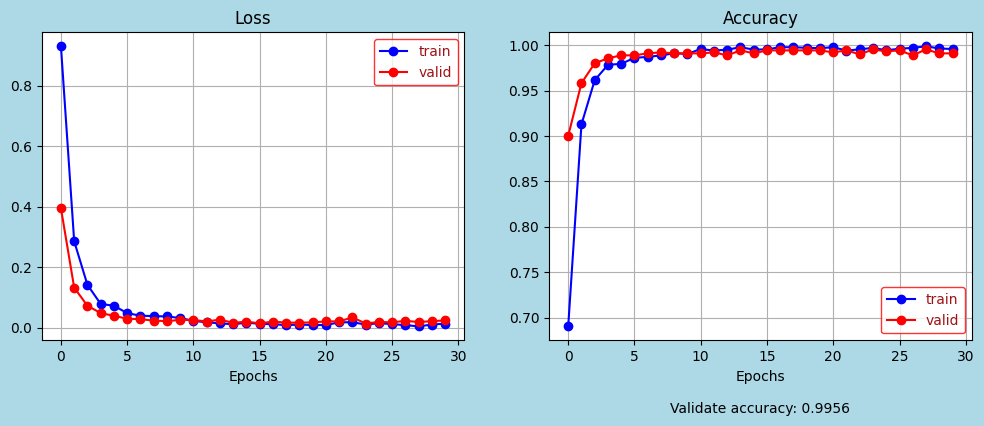

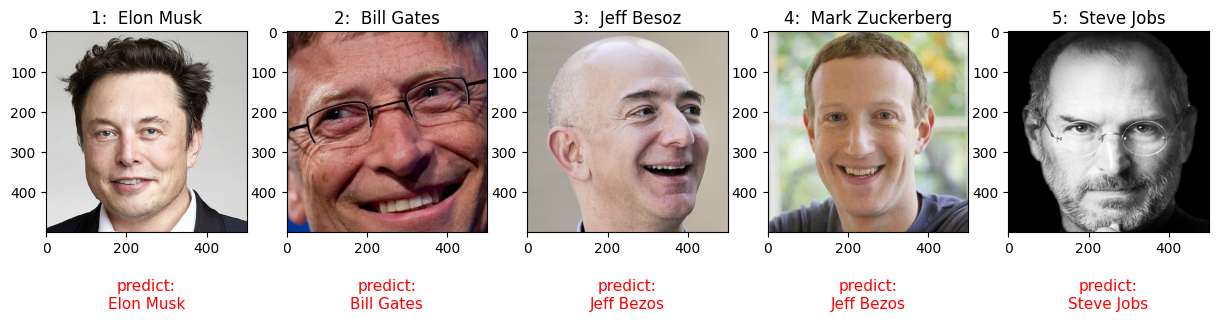

Model: VGG-16



100%|██████████| 30/30 [05:15<00:00, 10.51s/it]


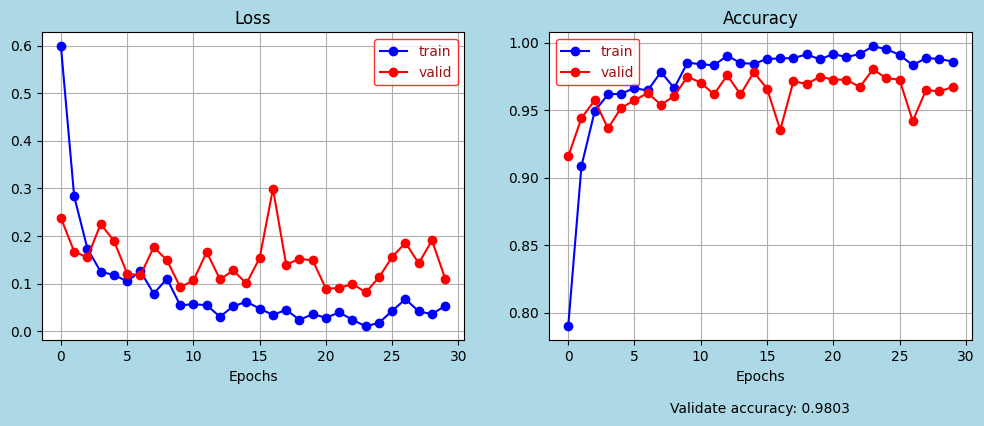

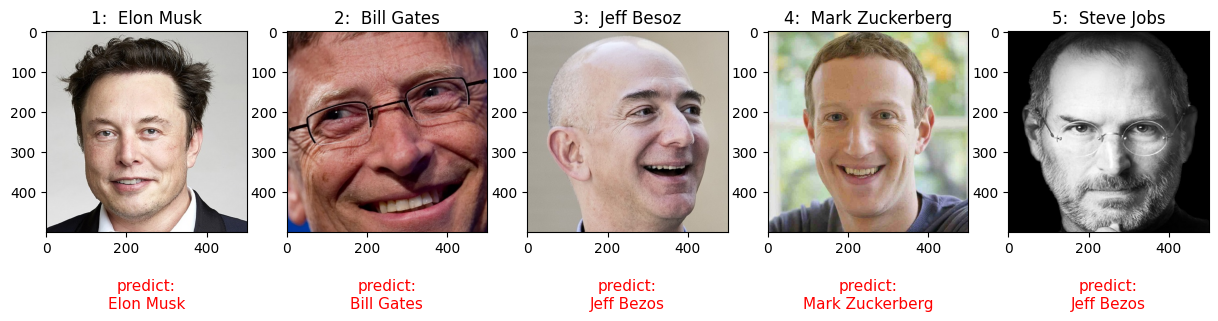

Model: EfficientNet_B7



100%|██████████| 30/30 [04:48<00:00,  9.61s/it]


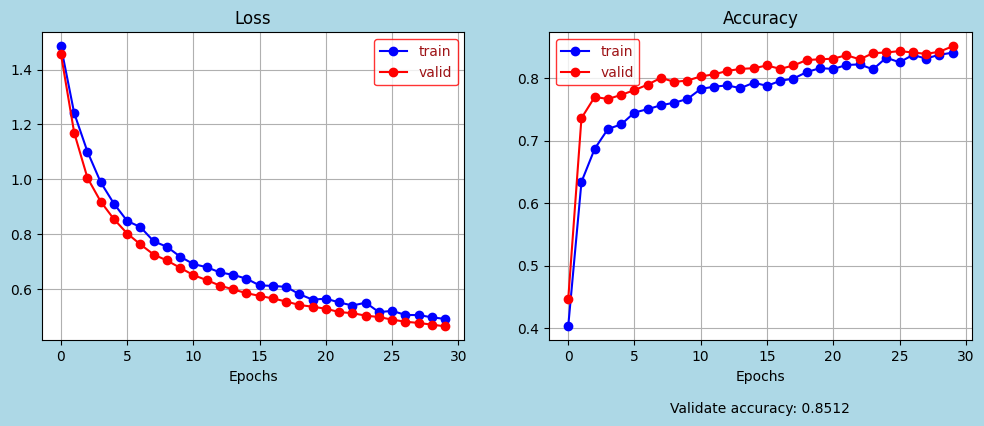

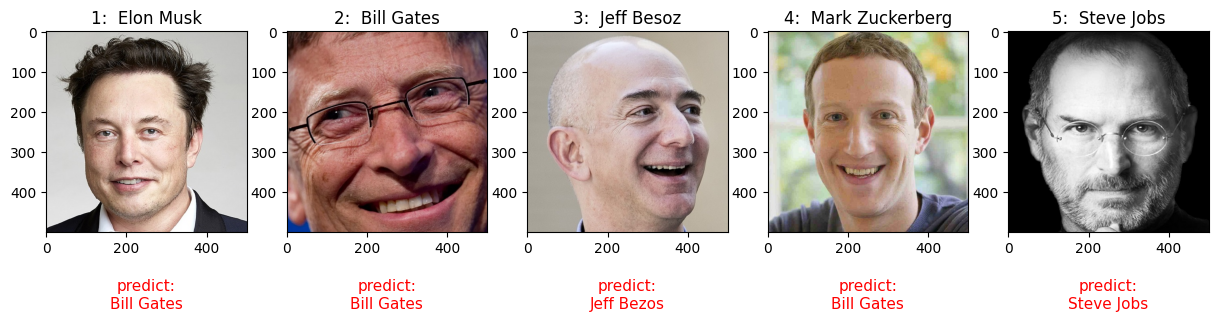

In [12]:
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

for i in range(3):
    if i == 0:
        model = google()
        print('Model: GoogLeNet\n')
    elif i == 1:
        model = vgg_19()
        print('Model: VGG-16\n')
    elif i == 2:
        model = efficient()
        print('Model: EfficientNet_B7\n')

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model = model.to(device)

    loss_train, acc_train, loss_valid, acc_valid = train(
    model, optimizer, train_loader, valid_loader, 30)
    plot_chart(loss_train, loss_valid, acc_train, acc_valid);
    face_predict(model, face_lst);
    del model
    torch.cuda.empty_cache()


<br>
<font color=#0DAC0B>
<font size=5><b>7. Выводы по полученным результатам</font>
</font>  
  
-------------------------------------------------

Был разработан классификатор для распознавания лиц. Использовались следующие предобученные сети:  
- `GoogLeNet`;  
  
- `VGG19`;  
  
- `EfficientNet_B7`.
  
На тонких настройках были заморожены все слои кроме, соответственно:  
- двух последних;  
  
- трёх последних;  
  
- двух последних.  
  
Обучение проводилось на 30-и эпохах.  
Соответственно, достигнутая точность `accuracy` на валидационной выборке:  
- `99.56 %`;  
  
- `98.03 %`;  
  
- `85.12 %`.
  
По первым двум графикам можно сделать однозначный вывод: наблюдается переобучение. Кривая `train` показывает лучшее положение, чем кривая `valid`, например, на втором графике значения точности обучающей выборки выще, чем валидационной. Такое может быть только при переобучении.  
Результат `accuracy` в 85.12 % показала третья модель, где использовалась предобученная сеть `EfficientNet_B7`. По графику видно, что переобучения нет, тем не менее, она допустила больше всех ошибок при распознавании лиц.  
Необходимо поработать с тонкими настройками и аугментацией. Эмпирически была подобрана скорость обучения равная 0.0001.  